In [ ]:
# from my experiments it seems like ExU units can't
# take 2D inputs so need to do the NAMs for multi-input
# but the residual based method seems to work for 2D at least!

In [1]:
# based on
# https://gitlab.com/SpaceTimeKhantinuum/scrinet/-/blob/master/examples/fits/nnfit-2d.ipynb

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

def relu_n(x, n = 1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)


class ExU(Layer):
    def __init__(self, units):
        super(ExU, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
        
    def call(self, inputs):
        
#         this tile is row_stack tf.shape(x)[0] times
        centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
        return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [4]:
import pugna.data

def preproc(data, method="MinMaxScaler", feature_range=(-1,1)):
    scalers = pugna.data.make_scalers(data, method=method, feature_range=feature_range)
    data_scaled = pugna.data.apply_scaler(data, scalers)
    return data_scaled, scalers

In [5]:
def gen_data(X):
    y = X[:,0] * np.sin(X[:,0]*10) + 1 + .4 * np.sin(X[:,1])
    y += np.random.uniform(0, 0.1, size=(len(y)))
    return y

In [6]:
# generate some fake data
x = np.linspace(0,1,10)
xx, yy = np.meshgrid(x,x)
xx = xx.ravel()
yy = yy.ravel()
X = np.zeros(shape=(len(xx), 2))
X[:,0] = xx
X[:,1] = yy

y = gen_data(X)

In [7]:
# validation data
# generate some fake data
x = np.linspace(0,1,20)
xx, yy = np.meshgrid(x,x)
xx = xx.ravel()
yy = yy.ravel()
X_val = np.zeros(shape=(len(xx), 2))
X_val[:,0] = xx
X_val[:,1] = yy

y_val = gen_data(X_val)

Text(0.5, 1.0, 'training set')

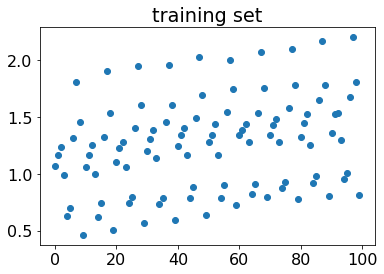

In [8]:
plt.figure()
plt.scatter(range(len(y)), y)
plt.title("training set")

In [9]:
plt.figure()
plt.scatter(range(len(y_val)), y_val)
plt.title("validation set")

Text(0.5, 1.0, 'validation set')

In [10]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(X[:,0], X[:,1], y, s=50)
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Z")
plt.title("training set")
plt.show()

In [11]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(X_val[:,0], X_val[:,1], y_val, s=50)
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Z")
plt.title("validation set")
plt.show()

In [12]:
X.shape

(100, 2)

In [13]:
y.shape

(100,)

In [14]:
def get_base_model(x, y, verbose=True, batch_size=None, epochs=500, validation_data=None):
    if batch_size is None:
        batch_size = x.shape[0]
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
#         tf.keras.layers.Dense(600, activation='tanh'),
#         tf.keras.layers.Dense(600, activation='tanh'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
#         tf.keras.layers.Dense(1),
#         ExU(1000),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.01, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)
    
    return history, model

In [15]:
def get_later_model(x, y, verbose=True, batch_size=None, epochs=500, validation_data=None):
    if batch_size is None:
        batch_size = x.shape[0]
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
#         tf.keras.layers.Dense(600, activation='tanh'),
#         tf.keras.layers.Dense(600, activation='tanh'),
        tf.keras.layers.Dense(400, activation='relu'),
        tf.keras.layers.Dense(400, activation='relu'),
        tf.keras.layers.Dense(400, activation='relu'),
        tf.keras.layers.Dense(400, activation='relu'),
#         tf.keras.layers.Dense(1),
#         ExU(1000),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.01, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)
    
    return history, model

In [16]:
%%time
history1, model1 = get_base_model(X, y, epochs=3000)

Epoch 1/3000
1/1 [==============================] - 0s 2ms/step - loss: 1.4890
Epoch 2/3000
1/1 [==============================] - 0s 603us/step - loss: 0.3806
Epoch 3/3000
1/1 [==============================] - 0s 553us/step - loss: 0.5416
Epoch 4/3000
1/1 [==============================] - 0s 953us/step - loss: 0.4466
Epoch 5/3000
1/1 [==============================] - 0s 647us/step - loss: 0.2509
Epoch 6/3000
1/1 [==============================] - 0s 867us/step - loss: 0.2491
Epoch 7/3000
1/1 [==============================] - 0s 1ms/step - loss: 0.3033
Epoch 8/3000
1/1 [==============================] - 0s 609us/step - loss: 0.3195
Epoch 9/3000
1/1 [==============================] - 0s 748us/step - loss: 0.2893
Epoch 10/3000
1/1 [==============================] - 0s 646us/step - loss: 0.2379
Epoch 11/3000
1/1 [==============================] - 0s 912us/step - loss: 0.2008
Epoch 12/3000
1/1 [==============================] - 0s 652us/step - loss: 0.2053
Epoch 13/3000
1/1 [==========

In [17]:
h1 = history1.history['loss']
plt.figure()
plt.plot(range(len(h1)), h1)
plt.yscale('log')

In [18]:
yhat = model1.predict(X)

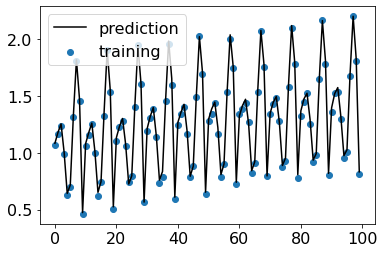

In [19]:
plt.figure()
plt.scatter(range(len(y)), y, label='training')
plt.plot(range(len(y)), yhat, label='prediction', c='k')
plt.legend()

In [20]:
yhat_val = model1.predict(X_val)

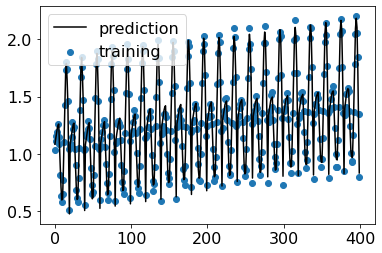

In [21]:
plt.figure()
plt.scatter(range(len(y_val)), y_val, label='training')
plt.plot(range(len(y_val)), yhat_val, label='prediction', c='k')
plt.legend()

In [22]:
plt.figure()
plt.scatter(range(len(y)), y - yhat.reshape(-1))
plt.title("training set difference")

Text(0.5, 1.0, 'training set difference')

Text(0.5, 1.0, 'training set difference')

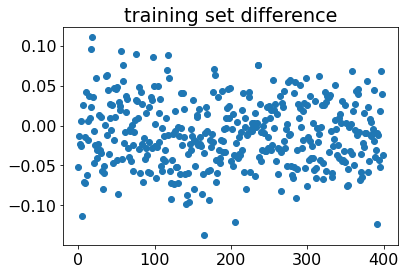

In [23]:
plt.figure()
plt.scatter(range(len(y_val)), y_val - yhat_val.reshape(-1))
plt.title("training set difference")

In [24]:
n_arr = np.arange(y.shape[0])
n_val_arr = np.arange(y_val.shape[0])

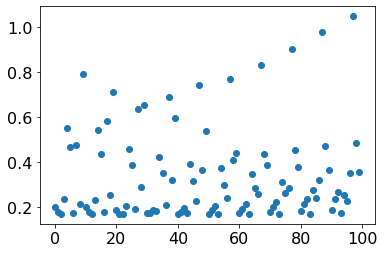

In [25]:
plt.figure()
plt.scatter(n_arr, tf.keras.losses.mean_squared_error(y, yhat))
# plt.yscale('log')

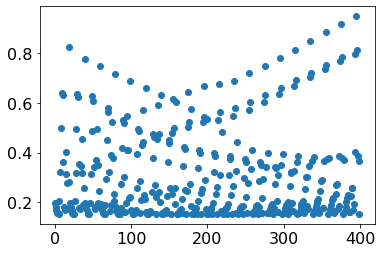

In [26]:
plt.figure()
plt.scatter(n_val_arr, tf.keras.losses.mean_squared_error(y_val, yhat_val))
# plt.yscale('log')

In [120]:
yRes = y - yhat[:,0]

In [121]:
y.shape

(100,)

In [122]:
yhat.shape

(100, 1)

In [123]:
yRes.shape

(100,)

In [124]:
yRes = yRes[:,np.newaxis]

In [125]:
yRes, scalers = preproc(yRes)

In [126]:
%%time
history2, model2 = get_later_model(X, yRes, epochs=1300)

Epoch 1/1300
1/1 [==============================] - 0s 1ms/step - loss: 0.1429
Epoch 2/1300
1/1 [==============================] - 0s 810us/step - loss: 12.5735
Epoch 3/1300
1/1 [==============================] - 0s 952us/step - loss: 0.1679
Epoch 4/1300
1/1 [==============================] - 0s 1ms/step - loss: 0.1524
Epoch 5/1300
1/1 [==============================] - 0s 1ms/step - loss: 0.1404
Epoch 6/1300
1/1 [==============================] - 0s 1ms/step - loss: 0.1394
Epoch 7/1300
1/1 [==============================] - 0s 816us/step - loss: 0.1381
Epoch 8/1300
1/1 [==============================] - 0s 827us/step - loss: 0.1343
Epoch 9/1300
1/1 [==============================] - 0s 649us/step - loss: 0.1357
Epoch 10/1300
1/1 [==============================] - 0s 849us/step - loss: 0.1331
Epoch 11/1300
1/1 [==============================] - 0s 1ms/step - loss: 0.1338
Epoch 12/1300
1/1 [==============================] - 0s 861us/step - loss: 0.1339
Epoch 13/1300
1/1 [===============

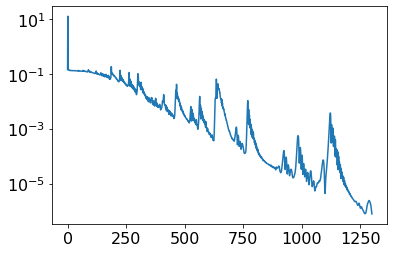

In [127]:
h2 = history2.history['loss']
plt.figure()
plt.plot(range(len(h2)), h2)
plt.yscale('log')

In [128]:
yhat2 = model2.predict(X)

In [129]:
yRes = pugna.data.apply_inverse_scaler(yRes, scalers)
yhat2 = pugna.data.apply_inverse_scaler(yhat2, scalers)

In [130]:
yRes.shape

(100, 1)

In [131]:
yhat2.shape

(100, 1)

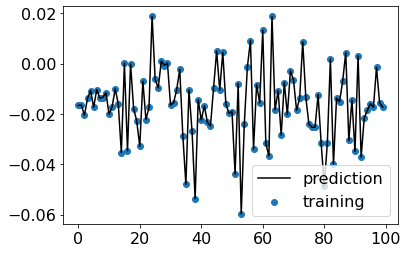

In [132]:
plt.figure()
plt.scatter(range(len(yRes)), yRes, label='training')
plt.plot(range(len(yRes)), yhat2, label='prediction', c='k')
plt.legend()

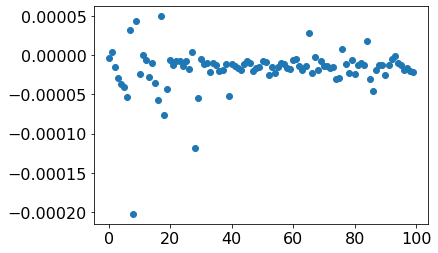

In [133]:
plt.figure()
plt.scatter(range(len(yRes)), yRes-yhat2)

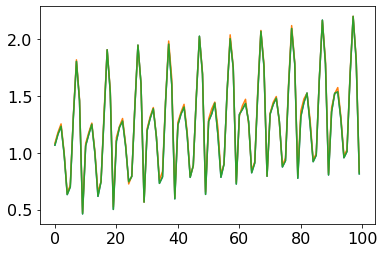

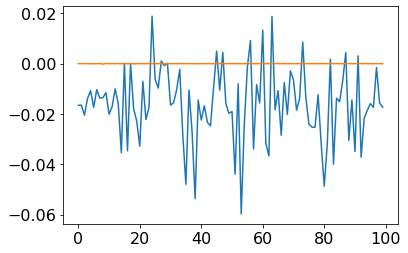

In [159]:
model1_pred = model1.predict(X)
model2_pred = model1.predict(X)+ pugna.data.apply_inverse_scaler(model2.predict(X), scalers)


plt.figure()
plt.plot(range(len(y)), y, label='training')
plt.plot(range(len(y)), model1_pred, label='m1')
plt.plot(range(len(y)), model2_pred, label='m2')

plt.figure()
plt.plot(range(len(y)), y-model1_pred[:,0], label='training-m1')
plt.plot(range(len(y)), y-model2_pred[:,0], label='training-m2')


In [167]:
yhat_multistep = model1.predict(X) \
    + pugna.data.apply_inverse_scaler(model2.predict(X), scalers)

yhat_val_multistep = model1.predict(X_val) \
    + pugna.data.apply_inverse_scaler(model2.predict(X_val), scalers)



In [141]:
yhat_multistep.shape

(100, 1)

In [161]:
y.shape

(100,)

In [162]:
yhat.shape

(100, 1)

In [163]:
yhat_multistep.shape

(100, 1)

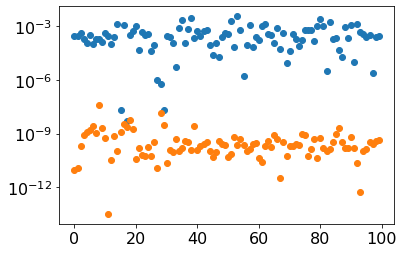

In [166]:
plt.figure()
plt.scatter(n_arr, tf.keras.losses.mean_squared_error(y[:,np.newaxis], yhat))
plt.scatter(n_arr, tf.keras.losses.mean_squared_error(y[:,np.newaxis], yhat_multistep))
plt.yscale('log')

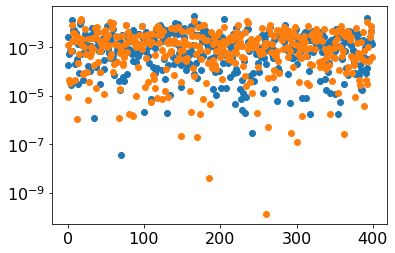

In [168]:
plt.figure()
plt.scatter(n_val_arr, tf.keras.losses.mean_squared_error(y_val[:,np.newaxis], yhat_val))
plt.scatter(n_val_arr, tf.keras.losses.mean_squared_error(y_val[:,np.newaxis], yhat_val_multistep))
plt.yscale('log')